In [1]:
import pandas  as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader
import torch.optim as optim
import matplotlib.pyplot as plt


In [2]:
BATCH_SIZE = 64
FILL_NAN= 10
TIME_STEP =30
COLUMN = 'cpu_consumption'
EPOCHS = 10
lr  = 0.002 
HIDDEN_LAYER_SIZE = 3
NUM_LAYERS=2
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


cpu


In [3]:
csv_file=  'results_cpu_memory_eco-efficiency.csv'
df = pd.read_csv(csv_file)
df.head()


,time,cpu_consumption,memory_consumption,energy_consumption,try
0,1.715680e+12,0.000000,220.467200,0.000000,1
1,1.715680e+12,5.559126,744.431616,3.969113,1
2,1.715680e+12,26.391754,852.066304,21.660497,1
3,1.715680e+12,34.193836,861.986816,24.031333,1
4,1.715680e+12,31.761820,829.640704,21.330805,1


In [4]:
def count_nan(df):
    nan_values = df.isna()
    nan_counts = df.isna().sum()
    return nan_counts

In [5]:
count_nan(df)

time                   0
cpu_consumption        0
memory_consumption     0
energy_consumption    14
try                    0
dtype: int64

In [6]:
df_ffill = df.ffill(limit=FILL_NAN)
df_bfill = df.bfill(limit=FILL_NAN)
df = (df_ffill + df_bfill) / 2

In [7]:
count_nan(df)

time                  0
cpu_consumption       0
memory_consumption    0
energy_consumption    0
try                   0
dtype: int64

In [8]:
from sklearn.preprocessing import StandardScaler

# Initialize a new StandardScaler instance
scaler = StandardScaler()

# Fit and transform the DataFrame
df  = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

<Axes: >

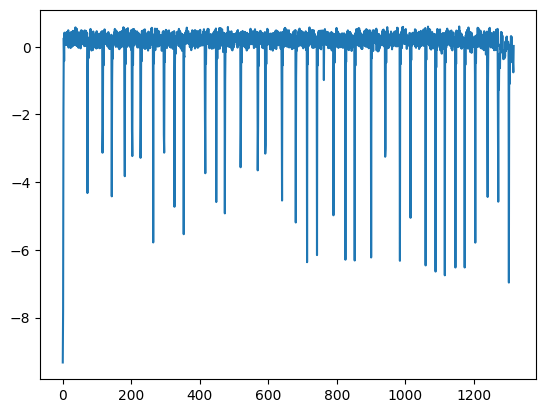

In [9]:
df[COLUMN].plot()

In [10]:
def train_test_split(df,split=0.8):
    train_split = int(len(df)*split)
    test_split=  len(df) -train_split
    return train_split,test_split

In [11]:
class LoadPredictionDataset(Dataset):
    def __init__(self,df,
                 start_index,
                 population,                 
                 time_step=TIME_STEP,
                 column=COLUMN,
                 device=device):
        previous_overflow=  max(start_index-time_step,0)
        df = df[column]
        self.df = df.iloc[previous_overflow:start_index+population]
        self.column = column
        self.time_step = time_step
        self.device = device
        self.length = len(self.df)-self.time_step -1
        
    def __getitem__(self, index):
        previous_values = self.df.iloc[index:index+self.time_step].values
        previous_values = torch.tensor(previous_values).unsqueeze(0)
        previous_values = previous_values.float().to(self.device)
        target_values = self.df.iloc[index+self.time_step]
        target_values = torch.tensor(target_values).float().to(self.device)
        target_values = target_values.unsqueeze(0)
        return previous_values, target_values
    
    def __len__(self):
        return self.length
        


In [12]:
train_split,test_split = train_test_split(df)

In [13]:
train_dataset = LoadPredictionDataset(df,start_index=0,population=train_split,device=device)
test_dataset  = LoadPredictionDataset(df,start_index=train_split,population=test_split,device=device)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


In [14]:
x=  next(iter(train_dataloader))
print(x[0].shape,x[1].shape)

torch.Size([64, 1, 30]) torch.Size([64, 1])


In [15]:

class LSTMModel(nn.Module):
    def __init__(self, input_size=TIME_STEP, hidden_layer_size=HIDDEN_LAYER_SIZE,num_layers =NUM_LAYERS, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size, hidden_layer_size,num_layers , batch_first=True)
        self.linear = nn.Linear(hidden_layer_size, output_size)



    def forward(self, input_seq):
        lstm_out, _ = self.lstm(input_seq)
        predictions = self.linear(lstm_out[:, -1, :])
     
        return predictions



In [16]:
model = LSTMModel().to(device)
model(x[0]).shape

torch.Size([64, 1])

In [17]:
def plot_results(model,dataset=test_dataset,dataloader=test_dataloader,column=COLUMN,device=device):
    results = torch.zeros(TIME_STEP,1).to(device)

    for data,_ in dataloader:
        res  = model(data)
        results = torch.cat((results,res),dim=0)
    plt.plot(results.detach().cpu(),color='r',label='Predicted')
    plt.plot(dataset.df.values,color='b',label='Real')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

In [18]:
# Assuming you have defined your model and train_dataloader
model = LSTMModel().to(device)


In [19]:
def train(model,train_dataloader=train_dataloader,device=device,criterion=None,optimizer=None):
    if criterion is None:
        criterion = nn.MSELoss()  # or any other loss function based on your task
    if optimizer is None:
        optimizer = optim.Adam(model.parameters(), lr=lr)  # or any other optimizer

    
    losses = []
    # Training loop
    for epoch in range(EPOCHS):  # number of epochs
        accumulative_loss = 0
        for i, data in enumerate(train_dataloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            accumulative_loss += loss.item()
        losses.append(accumulative_loss)
        if epoch %10 ==0:
            print(f"Epoch {epoch}, loss: {accumulative_loss / len(train_dataloader)}")


    print('Finished Training')
    plt.plot(losses)

In [ ]:
train(model)

Epoch 0, loss: 0.7675193315371871
Epoch 10, loss: 0.7280240028630942
Epoch 20, loss: 0.6372733903117478
Epoch 30, loss: 0.5734121659770608
Epoch 40, loss: 0.5018939352594316
Epoch 50, loss: 0.4139083568006754
Epoch 60, loss: 0.34034782857634127
Epoch 70, loss: 0.2809305740520358
Epoch 80, loss: 0.22531016264110804
Epoch 90, loss: 0.19312861247453839
Epoch 100, loss: 0.1651620725169778
Epoch 110, loss: 0.1449829962803051
Epoch 120, loss: 0.13040266290772706
Epoch 130, loss: 0.11895275418646634
Epoch 140, loss: 0.11020413902588189
Epoch 150, loss: 0.1014921865426004
Epoch 160, loss: 0.0955152401002124
Epoch 170, loss: 0.08987373695708811
Epoch 180, loss: 0.08496406709309667
Epoch 190, loss: 0.08047858183272183
Epoch 200, loss: 0.07745556475128978
Epoch 210, loss: 0.07384660723619163
Epoch 220, loss: 0.07101572793908417
Epoch 230, loss: 0.06784508586861193
Epoch 240, loss: 0.06672842311672866
Epoch 250, loss: 0.06470040266867727
Epoch 260, loss: 0.06276104948483407
Epoch 270, loss: 0.0614

In [ ]:
plot_results(model)

In [ ]:
plot_results(model,test_dataset,test_dataloader,device=device)